In [1]:

import tensorflow as tf
import keras
from keras.api.utils  import  to_categorical
from keras.api  import  Input, regularizers
from keras.api.layers  import  Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional, Embedding, Input
from keras.api.models  import  Model 
from keras.api.optimizers import Adam, SGD, RMSprop
from keras.api.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.api.models import load_model

import numpy as np

import matplotlib.pyplot as plt
import  os 
import random
import numpy as np



random_seed = 42
random.seed(random_seed)

tf.random.set_seed(random_seed)
keras.random.SeedGenerator(random_seed)

2024-12-21 18:01:53.927461: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 18:01:54.103352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734796914.170137 1433337 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734796914.189369 1433337 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 18:01:54.349217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
(X_train, y_train), (X_test, y_test) = keras.api.datasets.imdb.load_data()

In [3]:
# подивимось розподіл таргетів в датасеті

vals, counts = np.unique(y_train, return_counts=True)
test_vals, test_counts = np.unique(y_test, return_counts=True)

print(f"train_counts: {counts}, train_counts: {vals}\ntest_counts: {test_counts}, test_vals: {test_vals}")
# бачимо, що у нас ідеально збалансовані тестова та тренувальна вибірки за таргетами. У кожній вибірці по 25000 елементів

train_counts: [12500 12500], train_counts: [0 1]
test_counts: [12500 12500], test_vals: [0 1]


In [4]:
# так як ми працюємо з рекурентними шарами, нам потрібно розуміти довжину корпуса для того щоб визначити послідовність якого розміру ми будемо подавати

X_concated = np.concatenate((X_test, X_train), axis=0)

len_list = [len(sequence) for sequence in X_concated]
avrg_len = np.mean(len_list)
median_len = np.median(len_list)
print(f"avrg_len: {avrg_len}, median_len: {median_len}")

# бачимо що половина корпусів мають довжину <= 176 токенів. Проте середня довжина 235 каже нам про те, що значна частина корпусів має довжину більшу за 235 токенів
# проблема rnn моделей в затухаючих градієнтах - нейрони забувають надто довгі послідовності. 
# Тож Нам потрібно знайти баланс між середньою довжиною корпуса,  складністю моделі та кількістю інформації, яку ми готові втратити. 


avrg_len: 234.75892, median_len: 176.0


In [5]:
# подивимось скільки унікальних слів взагалі є в датасеті і скористужмось правилом Парето, як основою
word_index = keras.api.datasets.imdb.get_word_index()
total_words_count = len(word_index)
max_features = round(total_words_count * 0.2)
print(f"total_words_count: {total_words_count}, max_features: {max_features}")


total_words_count: 88584, max_features: 17717


In [6]:
from collections import Counter

word_counts = Counter(word for sequence in X_concated for word in sequence)
most_common_words = word_counts.most_common(max_features)
most_common_words[:10]

[(4, 666757),
 (5, 324337),
 (6, 322800),
 (7, 289379),
 (8, 268079),
 (9, 211041),
 (10, 201951),
 (11, 186690),
 (12, 156801),
 (13, 154887)]

In [7]:
# подивимось що у нас в топі 

reverse_word_index = {val: key for key, val in word_index.items()}



for token, freq in most_common_words[:100]:
    word = reverse_word_index.get(token - 3, f"<special_token_{token}>")  # перші 3 індекси - спеціальні і не є словами
    print(f"{word}, {freq}")

# бачимо що в топі найбільш частих слів є артиклі, займенники і тд. Наврядчи вони є значущими, тож видалимо їх. 

the, 666757
and, 324337
a, 322800
of, 289379
to, 268079
is, 211041
br, 201951
in, 186690
it, 156801
i, 154887
this, 150941
that, 136986
was, 95585
as, 91730
for, 87450
with, 87350
movie, 87050
but, 83495
film, 77678
on, 68015
not, 60697
you, 60308
are, 58363
his, 57541
have, 55186
be, 53360
one, 53034
he, 52543
<special_token_1>, 50000
all, 46881
at, 46784
by, 44464
an, 42932
they, 41920
so, 40845
who, 40624
from, 40481
like, 40153
or, 35746
just, 35154
her, 34771
out, 34155
about, 34152
if, 33951
it's, 33476
has, 33036
there, 31297
some, 31124
what, 30583
good, 29654
when, 28042
more, 28000
very, 27716
up, 26345
no, 25241
time, 25031
my, 24885
even, 24864
would, 24232
she, 24213
which, 23385
only, 23228
really, 23086
see, 22981
story, 22958
their, 22736
had, 22060
can, 21970
me, 21402
well, 21232
were, 21206
than, 19328
much, 19309
we, 19259
bad, 18393
been, 18348
get, 18335
do, 18187
great, 18121
other, 18097
will, 18087
also, 17974
into, 17846
people, 17828
because, 17711
how, 17587

In [8]:
# для видалення незначущих слів скористаємось бібліотекою nltk 

import nltk

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/pivden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
words = [reverse_word_index.get(token - 3, "") for token in X_train[0]]
words
filtered_words = [word for word in words if word and word not in stop_words]
len(filtered_words)

95

In [10]:
def remove_stopwords(seq):
    words = [reverse_word_index.get(token - 3, "") for token in seq]  # конвертуємо значення частоти слів в слова
    filtered_words = [word for word in words if word and word not in stop_words] # залишаємо тільки ті слова яких немає в  stop_words і які не є пустим рядком
    filtered_seq = [word_index[word] + 3 for word in filtered_words if word in word_index] # конвертуємо обратно слова в значення частоти їх застосування
    return  filtered_seq

In [11]:
def decode_corpus(corpus):
    decoded = " ".join([reverse_word_index[token] for token in corpus if token !=0])
    return decoded

In [12]:
decode_corpus(X_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

In [13]:
X_train_cleaned = np.array([remove_stopwords(seq) for seq in X_train], dtype=object)
X_test_cleaned = np.array([remove_stopwords(seq) for seq in X_test], dtype=object)

In [14]:
X_concated = np.concatenate((X_train_cleaned, X_test_cleaned), axis=0)

len_list = [len(sequence) for sequence in X_concated]
avrg_len = np.mean(len_list)
median_len = np.median(len_list)
print(f"avrg_len: {avrg_len}, median_len: {median_len}")

# бачимо що нам вдалось значно зменшити довжину корпусів. Думаю, тепер можемо встановити максимальну довжину корпуса в 130 токенів

avrg_len: 123.65304, median_len: 92.0


In [15]:
unique_values = np.unique(np.concatenate(X_concated))
unique_count = len(unique_values)
max_features_c = round(unique_count * 0.2)


print(f"unique_count: {unique_count}, max_features_cleared: {max_features_c}")
# бачимо що вцілому унікальних слів стало не набагато мало

unique_count: 88412, max_features_cleared: 17682


In [16]:
def get_path(log_dir):
    # створює унікальний шлях до директорії з логами
    i = 0
    while(True):
        log_path = os.path.join(log_dir, str(i))
        if not os.path.isdir(log_path):
            return log_path
        i = i + 1

In [17]:
logpath = get_path("./model_logs")
best_model_path = os.path.join(logpath, "best_model.keras")
EPOCHS = 30

In [18]:
from collections import defaultdict
from keras.api.callbacks import Callback


class PlotCallback(Callback):
    def __init__(self, log_path, figsize:tuple=(15, 10)):
        super().__init__()
        self.log_path = log_path
        self.metrics = defaultdict(list)
        self.figsize = figsize

        if not os.path.exists(self.log_path):
            os.makedirs(self.log_path)

    def on_epoch_end(self, epoch, logs=None):
        for key in logs.keys():
            self.metrics[key].append(logs[key])
        
        self._plot_metrics()

    def _plot_metrics(self):
        
        for metric in self.metrics:
            if "val_" in metric:
                continue
            plt.figure(figsize=self.figsize)
            plt.plot(self.metrics[metric], label=metric)
            validation_pair = self.metrics.get(f"val_{metric}", None)

            if validation_pair is not None:
                plt.plot(validation_pair, label=f"val_{metric}")
        
            plt.xlabel("epoch")
            plt.ylabel(metric)
            plt.title(f"training and validation {metric}")
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(self.log_path, f"{metric}.png"))
            plt.close()

In [19]:
saved_model_path ="saved_models"

In [20]:
def get_callbacks():
    best_model_cp = ModelCheckpoint(best_model_path, save_best_only=True, monitor="val_accuracy", verbose=1)
    plot_cb = PlotCallback(log_path=logpath)
    plateu_down_cb = ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=10, min_delta=0.00001, min_lr=0.0001)
    early_stopping_cb = EarlyStopping(monitor="val_accuracy", min_delta=0.0001, patience=10, restore_best_weights=True, verbose=1)
    return (best_model_cp, plot_cb, plateu_down_cb, early_stopping_cb)

In [21]:
from keras.api.preprocessing.sequence import pad_sequences 

In [22]:
max_len = 70
X_train_c = pad_sequences(X_train_cleaned, maxlen=max_len, padding="post")
X_test_c = pad_sequences(X_test_cleaned, maxlen=max_len, padding="post")

In [23]:
input = Input(shape=(max_len, ))
x = Embedding(input_dim=max_features_c, output_dim=32)(input)
x = SimpleRNN(64, return_sequences=False)(x)
output = Dense(1, activation="sigmoid")(x)

base_model = Model(inputs=input, outputs=output)

base_model.compile(
    optimizer="rmsprop", # adam == 0.781
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

base_model.summary()

In [24]:
base_model.fit(
    X_train_c, y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[get_callbacks()]
)

loss, accuracy = base_model.evaluate(X_test_c, y_test)
print(f"accuracy: {accuracy:.3f}\nloss: {loss:.3f}")

In [25]:
base_model.save(f"{saved_model_path}/base_model.keras")

In [26]:
max_len = 130

In [27]:
# перевіремо нашу теорію щодо вилучення стоп-слів
X_train_f, X_test_f = map(lambda x: pad_sequences(x, maxlen=max_len, padding="post"), [X_train, X_test])


In [28]:
print(decode_corpus(X_train[0]))
print(decode_corpus(X_train_f[0]))
print(decode_corpus(X_train_cleaned[0]))
print(decode_corpus(X_train_c[0]))

print(len(X_train_f[0]))

the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but whe

In [29]:
input = Input(shape=(max_len, )) 
x = Embedding(input_dim=max_features_c, output_dim=32)(input)
x = SimpleRNN(64, return_sequences=False)(x)
output = Dense(1, activation="sigmoid")(x)

base_model_full_dict = Model(inputs=input, outputs=output)

base_model_full_dict.compile(
    optimizer="rmsprop", 
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

base_model_full_dict.summary()

base_model_full_dict.fit(
    X_train_f, y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[get_callbacks()]
)

loss, accuracy = base_model_full_dict.evaluate(X_test_f, y_test)
print(f"accuracy: {accuracy:.3f}\nloss: {loss:.3f}")

З видаленням стоп-слів accuracy: 0.840 loss: 0.480, без видалення стоп-слів accuracy: 0.818 loss: 0.469. Бачимо, що видалення стоп-слів додало нам 2% до точності. Також варто зауважити, що видаливши стоп-слова ми використовували довжину послідовності 60 токенів, а без видалення нашим найкращім результатом була довжина в 130 токенів. Тобто видаливши стоп-слова ми не тільки відіграли в точності, але зменшили обсяг пам'яті та ресурси для предікту

In [30]:
# бачимо що видаленння стоп-слів допомогло yfv y, але не фантастично: вийшло відіграти десяту відсотка в точності та в loss. Але вцілому ідея була корисна

так як принцип побудови моделей однаковий, ми не будемо створювати багато однакового коду далі, а напишемо функцію, яка буде підбирати архітектуру та гіперпараметри для неї

In [31]:
from keras.api.regularizers import l1, l2, l1_l2

In [32]:
def build_model(hp, rnn_type, total_features, max_len=70):
    rnn_dict = {"SimpleRNN": SimpleRNN, "GRU": GRU, "LSTM": LSTM, "Bidirectional": Bidirectional}

    if not rnn_type in rnn_dict.keys():
        raise ValueError(f"rnn_type must be one of {rnn_dict.keys()}! got: {rnn_type}")
    
    
    regulizers = {"l1": l1, "l2": l2, "l1l2": l1_l2}
    reg_types_list = ["l1", "l2", "l1l2"]
    reg_rates_list = [0.0001, 0.0003, 0.0005, 0.001]
    dropout_rates = [0.2, 0.5, 0.7]
    bool_list = [True, False]
    activation_list = ["relu", "tanh"]
    
    max_features_prcntg = hp.Float("max_features_prcntg", 0.2, 1.0, step=0.2)
    max_features = int(total_features * max_features_prcntg)

    embedding_output_dim = hp.Int("embedding_output_dim", 16, 128, step=16)
    embedding_use_reg = hp.Choice("embedding_use_reg", bool_list)
    if embedding_use_reg:
        embeddings_regularizer_type = hp.Choice("embeddings_regularizer_type", reg_types_list)
        embeddings_regularizer_rate = hp.Choice("embeddings_regularizer_rate", reg_rates_list)

    rnn_layer1_units = hp.Int("rnn_layer1_units", 16, 128, step=16)
    rnn_layer1_use_reg = hp.Choice("rnn_layer1_use_reg", bool_list)
    if rnn_layer1_use_reg:
        rnn_layer1_kernel_reg = hp.Choice("rnn_layer1_kernel_reg", reg_types_list)
        rnn_layer1_kernel_reg_rate = hp.Choice("rnn_layer1_kernel_reg_rate", reg_rates_list)
    rnn_layer1_dropout = hp.Choice("rnn_layer1_dropout", dropout_rates)
    rnn_activation = hp.Choice("rnn_activation", activation_list)

    rnn_layers_count = hp.Choice("rnn_layers_count", [1, 2])

    use_hidden_dense = hp.Choice("use_hidden_dense", bool_list)

    optimizer_ch = hp.Choice("optimizer", ["SGD", "Adam", "RMSprop"])
    if optimizer_ch == "SGD":
        optimizer = SGD(
            learning_rate=hp.Float("learning_rate", 0.0005, 0.005, step=0.025),
            momentum=hp.Float("momentum", 0.0, 0.9, step=0.3)
        )
    elif optimizer_ch == "RMSprop":
        optimizer = RMSprop(
            learning_rate=hp.Float("learning_rate", 0.0005, 0.005, step=0.025)
        )
    elif optimizer_ch == "Adam":
        optimizer = Adam(
            learning_rate=hp.Float("learning_rate", 0.0005, 0.005, step=0.025)
        )

    input_layer = Input(shape=(max_len,))
    x = Embedding(
        input_dim=max_features,
        output_dim=embedding_output_dim,
        embeddings_regularizer=regulizers[embeddings_regularizer_type](embeddings_regularizer_rate) if embedding_use_reg else None
    )(input_layer)

    # перший рекурентний шар
    if rnn_type == "Bidirectional":
        x = Bidirectional(LSTM(
            units=rnn_layer1_units,
            kernel_regularizer=regulizers[rnn_layer1_kernel_reg](rnn_layer1_kernel_reg_rate) if rnn_layer1_use_reg else None,
            dropout=rnn_layer1_dropout,
            return_sequences=False,
            activation=rnn_activation
        ))(x)
    else:
        x = rnn_dict[rnn_type](
            units=rnn_layer1_units,
            kernel_regularizer=regulizers[rnn_layer1_kernel_reg](rnn_layer1_kernel_reg_rate) if rnn_layer1_use_reg else None,
            dropout=rnn_layer1_dropout,
            return_sequences=False if rnn_layers_count == 1 else True,
            activation=rnn_activation
        )(x)
        
        if rnn_layers_count == 2:
            # визначення параметрів другого рекурентного шару
            rnn_layer2_units = hp.Int("rnn_layer2_units", 16, 128, step=16)
            rnn_layer2_use_reg = hp.Choice("rnn_layer2_use_reg", bool_list)
            if rnn_layer2_use_reg:
                rnn_layer2_kernel_reg = hp.Choice("rnn_layer2_kernel_reg", reg_types_list)
                rnn_layer2_kernel_reg_rate = hp.Choice("rnn_layer2_kernel_reg_rate", reg_rates_list)
            rnn_layer2_dropout = hp.Choice("rnn_layer2_dropout", dropout_rates)
            rnn2_activation = hp.Choice("rnn2_activation", activation_list)

            # другий рекурентний шар
            x = rnn_dict[rnn_type](
            units=rnn_layer2_units,
            kernel_regularizer=regulizers[rnn_layer2_kernel_reg](rnn_layer2_kernel_reg_rate) if rnn_layer2_use_reg else None,
            dropout=rnn_layer2_dropout,
            return_sequences=False,
            activation=rnn2_activation
        )(x)

    if use_hidden_dense:
        # визначення параметрів додаткового повнозв'язного шару
        hd_units = hp.Int("hd_units", 32, 128, step=32)
        hd_activation = hp.Choice("hd_activation", activation_list)
        hd_use_reg = hp.Choice("hd_use_reg", bool_list)
        if hd_use_reg:
            hd_reg = hp.Choice("hd_reg", reg_types_list)
            hd_reg_rate = hp.Choice("hd_reg_rate", reg_rates_list)
        

        use_hd_dropout = hp.Choice("use_hd_dropout", bool_list)
        # додатковий повнозв'язний шар
        x = Dense(
            hd_units, 
            activation=hd_activation,
            kernel_regularizer=regulizers[hd_reg](hd_reg_rate) if hd_use_reg else None)(x)
        if use_hd_dropout:
            # дропаут для додаткового повнозв'язного шару
            hd_dropout_rate = hp.Choice("hd_dropout_rate", dropout_rates)
            x = Dropout(hd_dropout_rate)(x)

    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# як же криво вона написана... Зато сам, наступного разу буде кращє

In [33]:
from keras_tuner import Hyperband
import keras.api.backend as K
import gc

In [34]:
total_features = len(unique_values)

In [35]:
max_len_list = [60, 90, 110, 130, 150, 200]

for max_len in max_len_list:
    X_train_c, X_test_c = map(lambda x: pad_sequences(x, maxlen=max_len, padding="post"), [X_train_cleaned, X_test_cleaned])

    for rnn_type in ["SimpleRNN", "GRU", "LSTM", "Bidirectional"]:
        
        #очищення пам'яті та збір сміття
        K.clear_session() 
        gc.collect()

        tuner = Hyperband(
            lambda hp: build_model(hp, rnn_type, total_features, max_len=max_len),
            objective='val_accuracy',
            max_epochs=40,
            factor=3,
            directory=f"{rnn_type}_seq{max_len}",
            project_name='imdb'
        )


        tuner.search(X_train_c, y_train, validation_split=0.2, epochs=50, batch_size=128, callbacks=[get_callbacks()[-1]])

        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Best hyperparameters: {best_hps.values}")

        best_model = tuner.get_best_models()[0]
        model_name = f"best_{rnn_type}_corp{max_len}"
        best_model.name = model_name
        best_model.save(f"saved_models/{model_name}.keras")

        with open("results_log.txt", "a") as log_file:
            log_file.write(f"{model_name}: {best_hps.values}\n")

In [52]:
import time


def get_predict_time(model, sample):
    sample = np.expand_dims(sample, axis=0)
    start_time = time.time()
    model.predict(sample, verbose=0)
    predict_time = time.time() - start_time
    
    return predict_time

In [78]:
# завантажимо усі моделі для порівняння
max_len_list = [200, ]
model_names = os.listdir("saved_models")
model_names = sorted(model_names, key=lambda x: int(x.split("corp")[1].split(".")[0]))
models_dict = dict()

for name in model_names:
    print(name)

    K.clear_session() 
    gc.collect()
    
    model = load_model(f"saved_models/{name}")
    modelname = name.replace(".keras", "").replace("best_", "")
    params = model.count_params()
    max_len = int(modelname.split("corp")[1])
    X_test_c = pad_sequences(X_test_cleaned, maxlen=max_len, padding="post")
    
    loss, accuracy = model.evaluate(X_test_c, y_test)
    
    predic_time = get_predict_time(model, X_test_c[42])
    models_dict[name] = {
        "name": modelname,
        "params": params,
        "loss": loss,
        "accuracy": accuracy,
        "predict_time": predic_time
    }


    

best_Bidirectional_corp60.keras


/home/pivden/HilelML/venv-hilelml/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8461 - loss: 0.3683
best_GRU_corp60.keras


/home/pivden/HilelML/venv-hilelml/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8534 - loss: 0.3535
best_LSTM_corp60.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8416 - loss: 0.3958
best_SimpleRNN_corp60.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8426 - loss: 0.4403
best_LSTM_corp90.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8616 - loss: 0.3858
best_Bidirectional_corp90.keras


/home/pivden/HilelML/venv-hilelml/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8498 - loss: 0.4123
best_SimpleRNN_corp90.keras


/home/pivden/HilelML/venv-hilelml/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8587 - loss: 0.4604
best_GRU_corp90.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8586 - loss: 0.3565
best_Bidirectional_corp110.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8557 - loss: 0.3993
best_LSTM_corp110.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8606 - loss: 0.3404
best_SimpleRNN_corp110.keras


/home/pivden/HilelML/venv-hilelml/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8672 - loss: 0.3370
best_GRU_corp110.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.8631 - loss: 0.3547
best_LSTM_corp130.keras


/home/pivden/HilelML/venv-hilelml/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8710 - loss: 0.3842
best_GRU_corp130.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.8563 - loss: 0.4445
best_Bidirectional_corp130.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8618 - loss: 0.3958
best_SimpleRNN_corp130.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8720 - loss: 0.3714
best_Bidirectional_corp150.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8659 - loss: 0.3797
best_LSTM_corp150.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8582 - loss: 0.3967
best_SimpleRNN_corp150.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8668 - loss: 0.4709
best_GRU_corp150.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8680 - loss: 0.3651
best_GRU_corp200.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8606 - loss: 0.4681
best_Bidirectional_corp200.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8713 - loss: 

In [79]:
def add_bar_value(ax, bar, color) -> None:
    for i in bar:
        yval = i.get_height()
        ax.text(i.get_x() + i.get_width() / 2, yval + 0.01 , f"{round(yval * 100, 2) if yval < 1 else yval / 1_000_00}", ha='center', va='bottom', fontsize=10, color=color)

In [103]:

def plot_models_metrics(models_dict):
    models = [models_dict[model]["name"] for model in models_dict.keys()]

    accuracy = [models_dict[model]["accuracy"] * 100 for model in models_dict.keys()]
    loss = [models_dict[model]["loss"] * 100 for model in models_dict.keys()]
    predict_time = [models_dict[model]["predict_time"] * 100 for model in models_dict.keys()]
    params = [models_dict[model]["params"] / 1e6 for model in models_dict.keys()]

    x = range(len(models))
    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.2

    bar_accuracy = ax.bar([i - 1.5 * bar_width for i in x], accuracy, width=bar_width, label="accuracy", color="blue")
    bar_loss = ax.bar([i - 0.5 * bar_width for i in x], loss, width=bar_width, label="loss", color="orange")
    bar_predict_time = ax.bar([i + 0.5 * bar_width for i in x], predict_time, width=bar_width, label="predict time (ms)", color="green")
    bar_params = ax.bar([i + 1.5 * bar_width for i in x], params, width=bar_width, label="params (M)", color="red")

    for bar in bar_accuracy:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=9)
    for bar in bar_loss:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=9)
    for bar in bar_predict_time:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.1f}", ha="center", va="bottom", fontsize=9)
    for bar in bar_params:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.1f}", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("vals")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


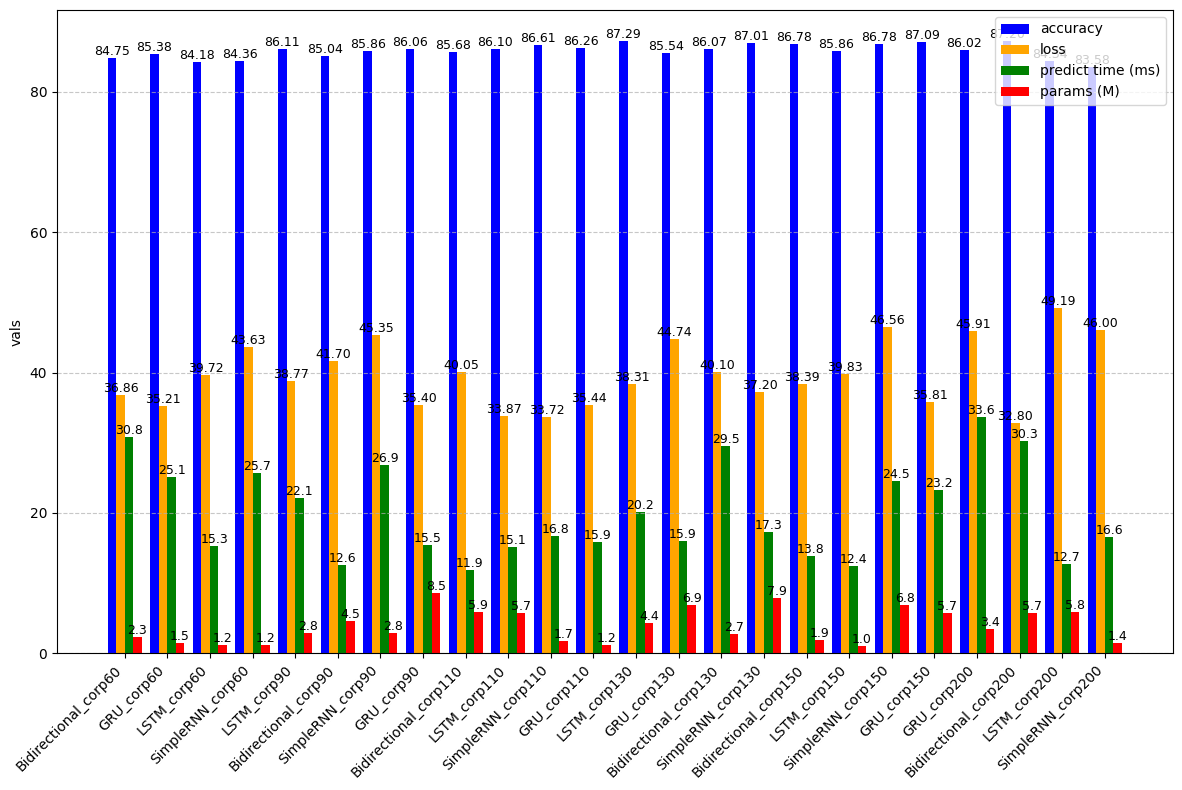

In [104]:

plot_models_metrics(models_dict)

In [105]:

best_model_by_accuracy = max(models_dict.items(), key=lambda x: x[1]['accuracy'])
best_model_by_time = min(models_dict.items(), key=lambda x: x[1]['predict_time'])
min_params_model = min(models_dict.items(), key=lambda x: x[1]['params'])

print(f"best_model_by_accuracy\nname: {best_model_by_accuracy[0]}, metrics: {best_model_by_accuracy[1]}")
print(f"\nbest_model_by_time\nname: {best_model_by_time[0]}, metrics: {best_model_by_time[1]}")
print(f"\nmin_params_model\nname: {min_params_model[0]}, metrics: {min_params_model[1]}")


best_model_by_accuracy
name: best_LSTM_corp130.keras, metrics: {'name': 'LSTM_corp130', 'params': 4350897, 'loss': 0.3831227719783783, 'accuracy': 0.8728799819946289, 'predict_time': 0.20152759552001953}

best_model_by_time
name: best_Bidirectional_corp110.keras, metrics: {'name': 'Bidirectional_corp110', 'params': 5856257, 'loss': 0.40054428577423096, 'accuracy': 0.8568400144577026, 'predict_time': 0.11873245239257812}

min_params_model
name: best_LSTM_corp150.keras, metrics: {'name': 'LSTM_corp150', 'params': 1015665, 'loss': 0.39825475215911865, 'accuracy': 0.8586000204086304, 'predict_time': 0.12442517280578613}


In [106]:
best_models = {key: models_dict[key] for key in models_dict.keys() if key in [best_model_by_accuracy[0], best_model_by_time[0], min_params_model[0]]}

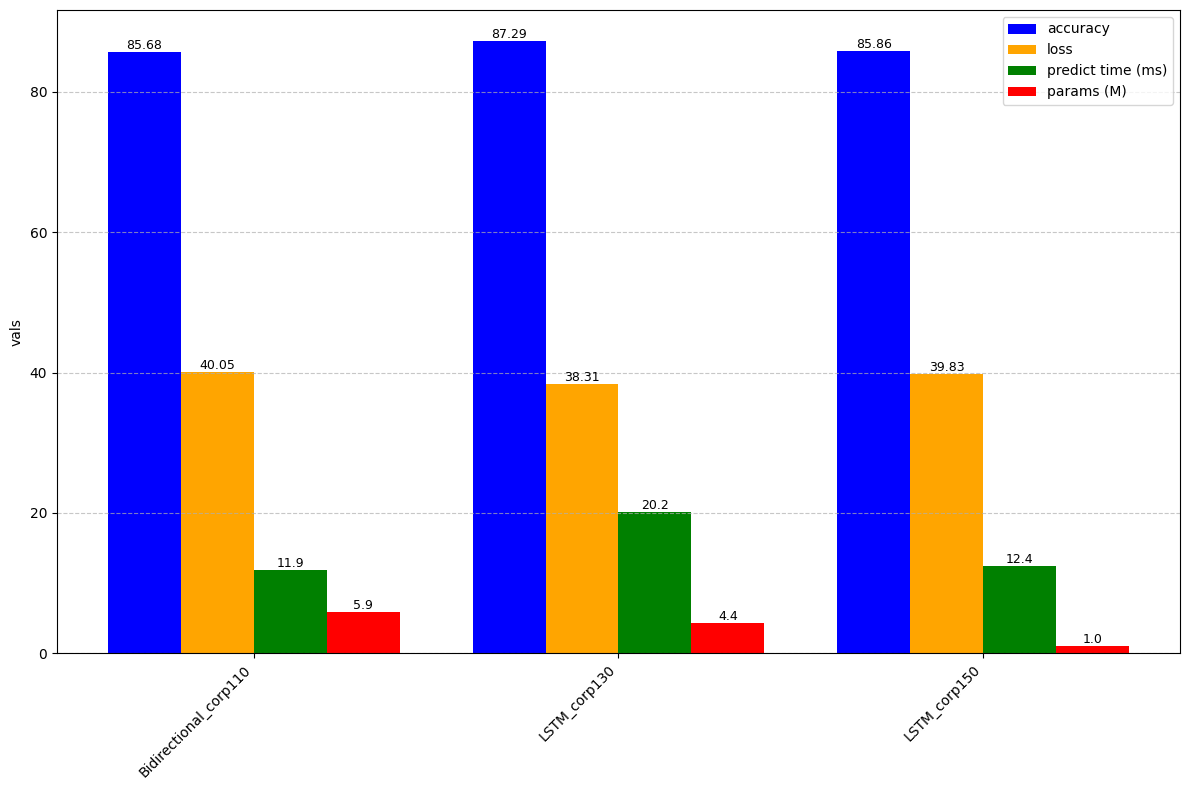

In [107]:

plot_models_metrics(best_models)

In [ ]:
# як бачимо найкращим варіантом з точки зору ціна-якість була б модель LSTM з довжиною послідовностей 150 токенів:
#  всього на 1.4% менше точність від кращої, але при цьому на 60% швидший інференс. Також має найменшу кількість параметрів, що заощаджує пам'ять

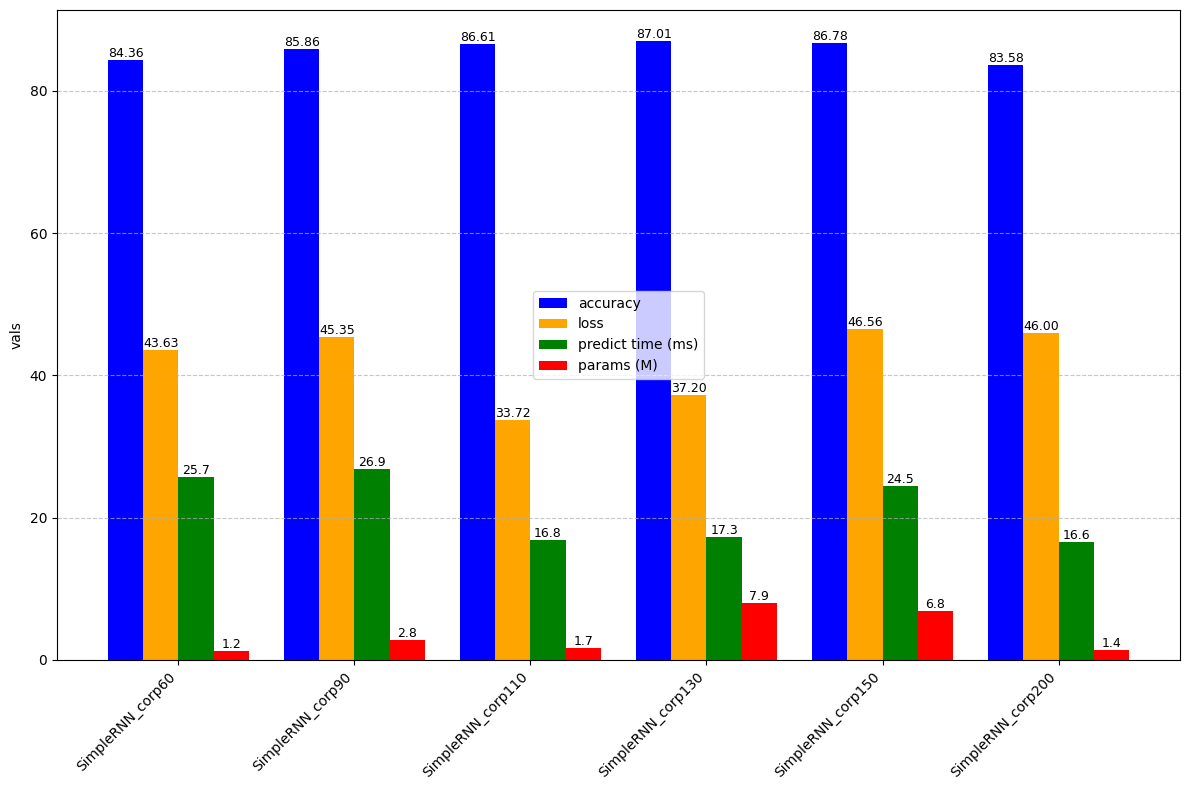

In [115]:
simple_rnn_models = {key: models_dict[key] for key in models_dict.keys() if "SimpleRNN" in key}

plot_models_metrics(simple_rnn_models)

In [118]:
print(f"median_len: {median_len}\navg_len: {avrg_len}")

median_len: 92.0
avg_len: 123.65304


In [ ]:
# бачимо, що найкраща модель на шарах simpleRnn тим точніша, 
# чим ближча довжина послідовності до середньої довжини корпуса і чим дальше від неї, тим більше втрачається точність

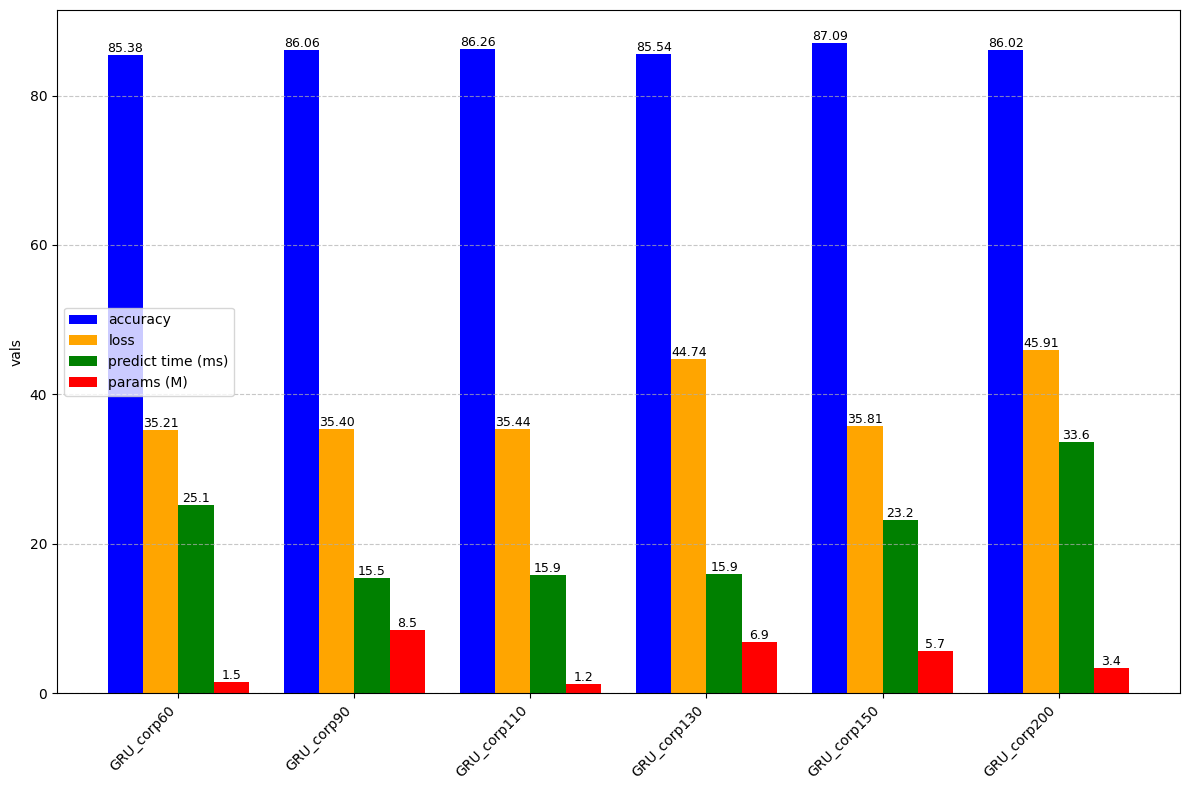

In [ ]:
gru_models = {key: models_dict[key] for key in models_dict.keys() if "GRU" in key}

plot_models_metrics(gru_models)

тут можемо виділити моделі з довжиною послідовності 110 та 150: остання має трохи вищу точність, але на чверть довший інференс та майже в 5 разів більше параметрів

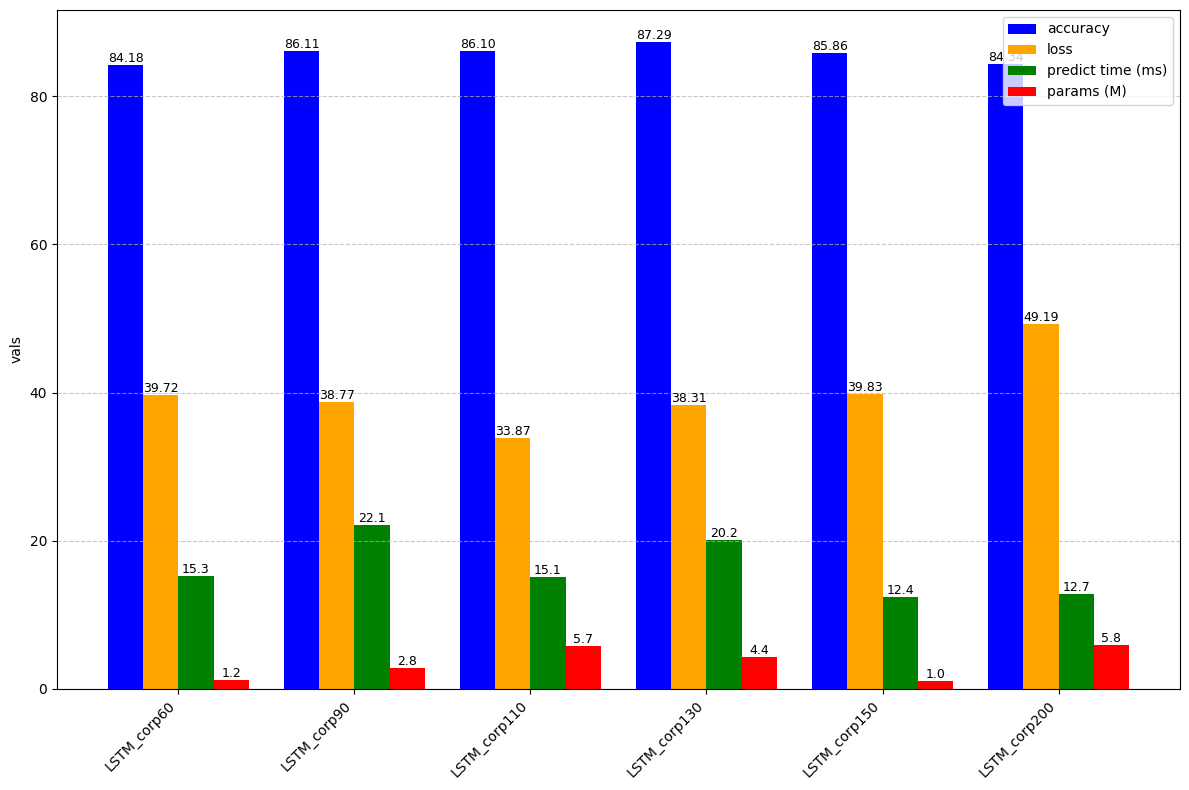

In [121]:
lstm_models = {key: models_dict[key] for key in models_dict.keys() if "LSTM" in key}

plot_models_metrics(lstm_models)

тут також найточніша модель має довжину послідовностей найближчу до середньої довжини корпусів. Можна було б побачити залежність складності від довжини послідовності, але ні: бачимо що 150 модель взагалі маж всбого 1 мілліон тренованих параметрів

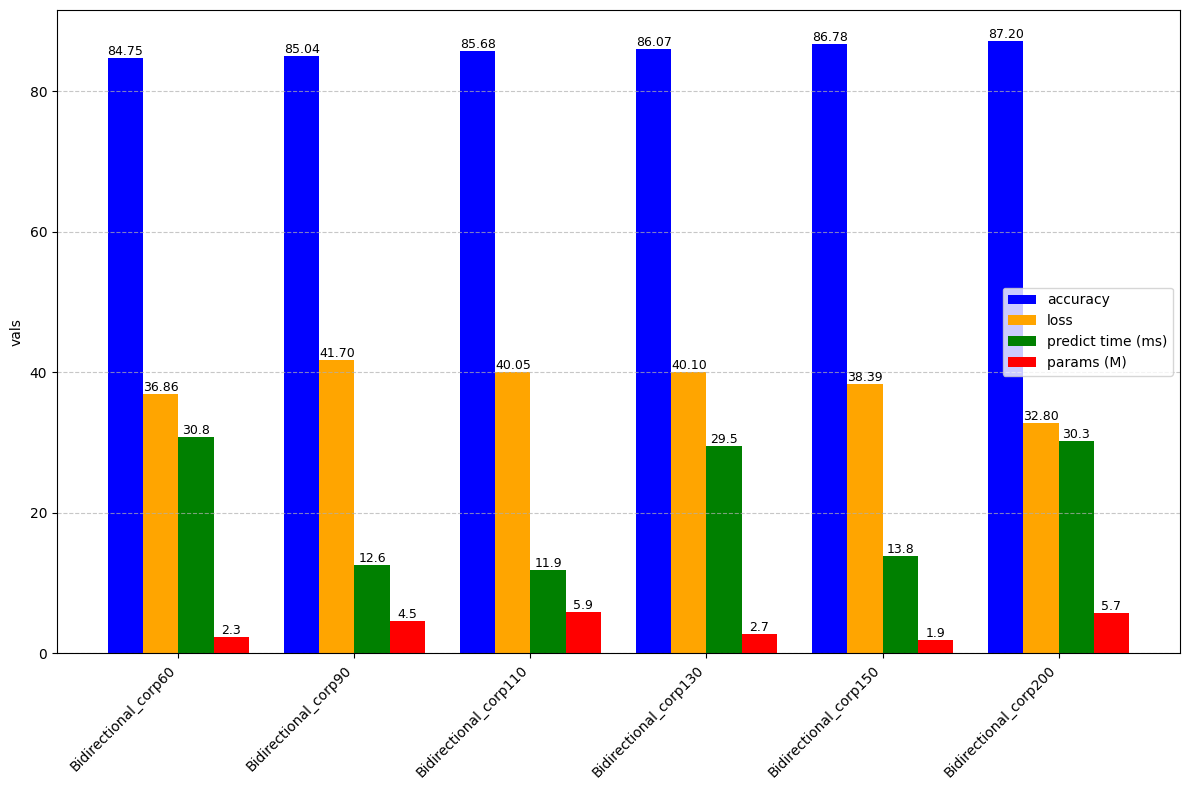

In [133]:
bidirectional_models = {key: models_dict[key] for key in models_dict.keys() if "Bidirectional" in key}

plot_models_metrics(bidirectional_models)

Тут ми бачимо явну тенденцію зростання точності від довжини послідовності, але також бачимо суттєвий розброс в часі інференсу

Застосування Hyperband не зарантує нам піддбору оптимальних параметрів для збереження найкращої архітектури та параметрів з точки зору ціна-якість. Також я помітив що rnn моделі тренуються досить швидко, але досить нестабільно, тож перший пул відбору має відбуватись мінімум на 3 епохах для того щоб модель дійсно змогла показати хороший результат, інакше вона буде відсіяна. без шансів пройти далі

Тут ми не побачили суттєвої різниці в застосуванні rnn шарів. Можливо через те що hyperband знов таки підбирає архітектуру так, щоб дотягнути accuracy вгору. Також ми значно зменшили довжину корпусів, вилучивши стоп-слова. Імовірно, якщо б ми це не зробили, lstm та bidirectional(lstm) змогли би реалізувати свій потенціал, але за рахунок збільшення обсягу ресурсів